# Content

In this notebook we detail the technique for automatically detecting inner-iterations.

# Imports and Globals

Here are the python packages that must be available to run the script.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tools import *

Below are the global path variables where are stored curves and pre-computed data (from other notebooks).
Please adapt to your personnal installation.

In [2]:
# adapt here the pathes to your configuration (be sure directories exist)
curve_directory = '../data'
tmp_directory = './tmp'
curve_filename  = 'bike_cortexm4_20_traces.npy'

In [3]:
curves = np.load(os.path.join(curve_directory,curve_filename))[:20]
# the following values are obtained in the Outer-Iterations Detection notebook that must have been executed first !
outer_iterations_bounds_all = np.load(os.path.join(tmp_directory,'outer_iterations_bounds.npy'))
outer_iterations_bounds = outer_iterations_bounds_all[0]

# Inner-Iterations when Syndrome is Non-Zero

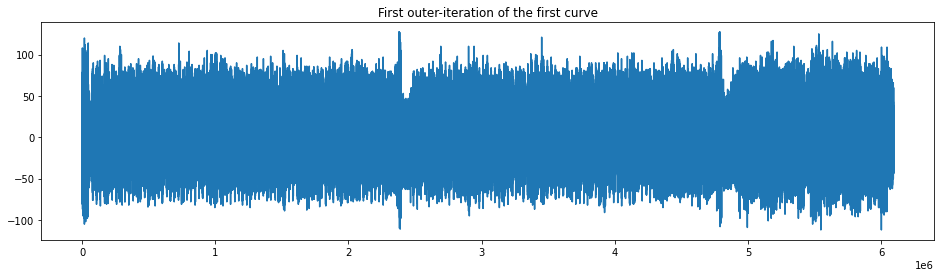

In [4]:
fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.plot(curves[0][outer_iterations_bounds[0]:outer_iterations_bounds[1]])
ax.set_title("First outer-iteration of the first curve")
plt.show()

We see that the outer iteration is composed of three parts. Two really similar ones that correspond to the same loop executed on each half of the secret data (namely $h_0$ and $h_1$). The third one being the decision part based on the results of the multiplication.

For the attack we focus on the multiplication that is the two first parts.
Let's take a look at the first one.

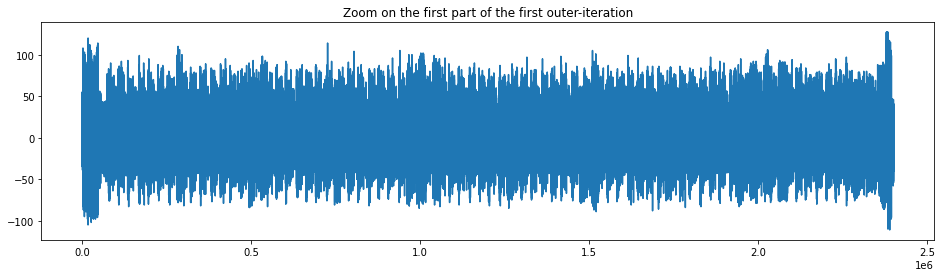

In [5]:
fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.plot(curves[0][outer_iterations_bounds[0]:outer_iterations_bounds[0]+2400000])
ax.set_title("Zoom on the first part of the first outer-iteration")
plt.show()

It really looks like a loop of inner iterations. Let's apply our magical 'simplifying' function.

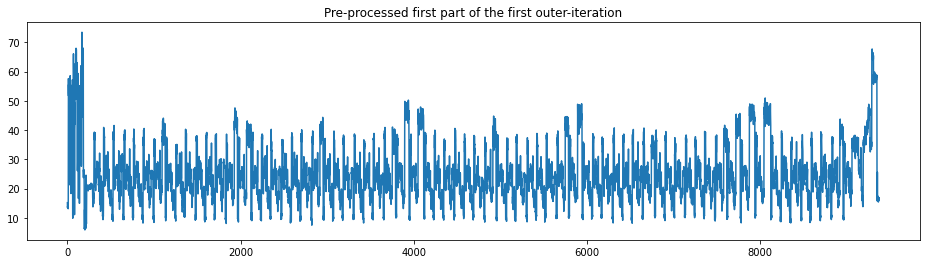

In [6]:
# loop_curve_1 will contain the first part of the outer-iteration
loop_curve_1 = curves[0][outer_iterations_bounds[0]:outer_iterations_bounds[0]+2400000]
temp = simplify_pattern(loop_curve_1, decimation=256)

fig = plt.figure(figsize=(16,4))
ax = fig.gca()
ax.plot(temp)
ax.set_title("Pre-processed first part of the first outer-iteration")
plt.show()

Ok, except some strange occurrences it seems that we have a repeating pattern that we can try to detect.
To speed-up detection, we would like to use the same kind of pre-processing technique than for outer-iterations.
However, this will not work as smoothly due to the few *strange* patterns.

We will take a look at the corresponding *raw* patterns (recall that the curve above is processed).

> Remark.
> We did not investigated the root cause of these *strange* patterns but it might be a useful source of information too.
> By the way, those patterns are longer than the classical ones.

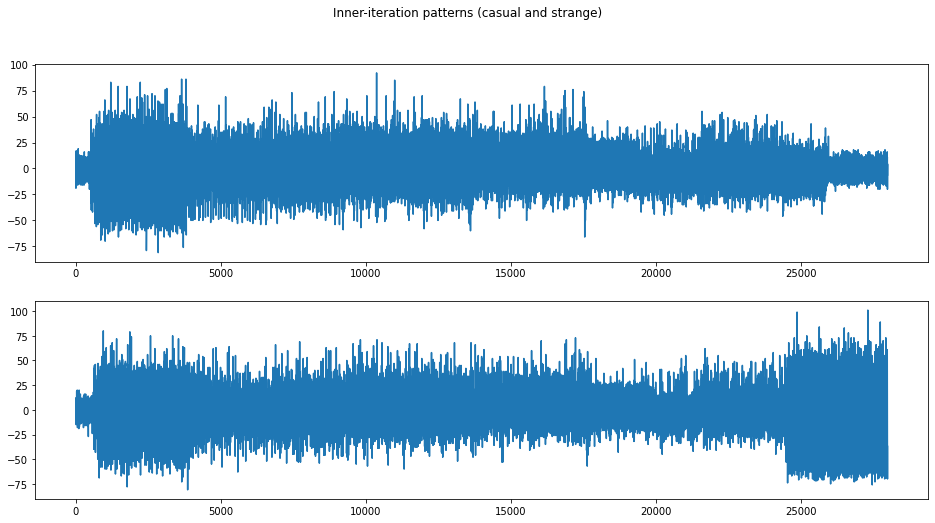

In [7]:
inner_pattern1 = curves[0][outer_iterations_bounds[0]+106000:outer_iterations_bounds[0]+134000]
inner_pattern2 = curves[0][outer_iterations_bounds[0]+255500:outer_iterations_bounds[0]+283500]

fig, axes = plt.subplots(2,1,figsize=[16,8])
axes[0].plot(inner_pattern1)
axes[1].plot(inner_pattern2)
fig.suptitle("Inner-iteration patterns (casual and strange)")
plt.show()

We see that actually they coincide up to a point where the first (most found) pattern has a small time of computation then seems to be in idle state while the second one starts having a huge power consumption.

We can then only focus on their common part and see if it works well enough.

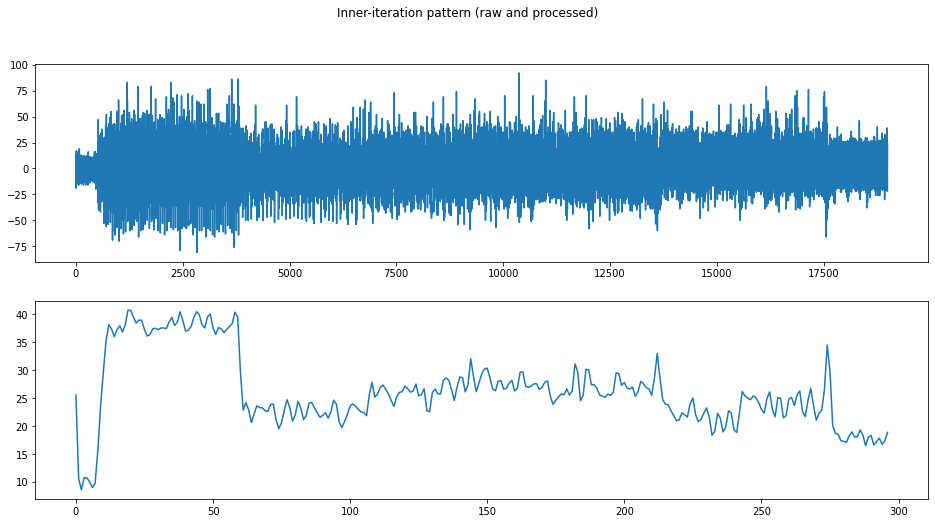

In [8]:
inner_pattern = curves[0][outer_iterations_bounds[0]+106000:outer_iterations_bounds[0]+125000]
proc_inner_pattern = simplify_pattern(inner_pattern, decimation=64)

fig, axes = plt.subplots(2,1,figsize=[16,8])
axes[0].plot(inner_pattern)
axes[1].plot(proc_inner_pattern)
fig.suptitle("Inner-iteration pattern (raw and processed)")
plt.show()
np.save(os.path.join(tmp_directory,'raw_inner_iteration_pattern_nonzero.npy'),inner_pattern)

Number of detected peaks: 71


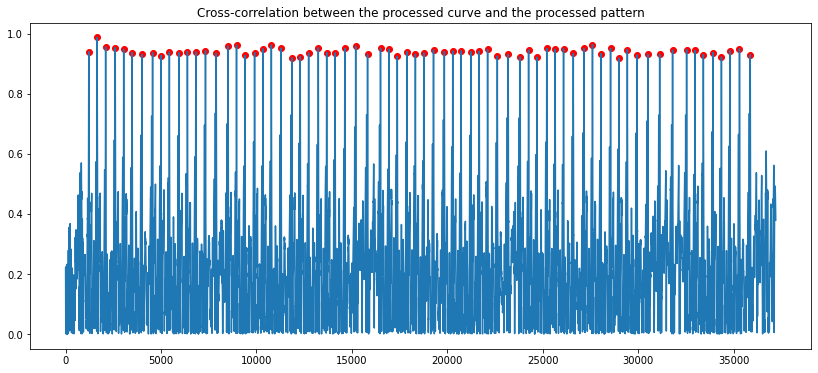

CPU times: user 3.72 s, sys: 171 ms, total: 3.89 s
Wall time: 3.72 s


In [9]:
%%time
loop_curve_1 = curves[0][outer_iterations_bounds[0]:outer_iterations_bounds[0]+2400000]
proc_loop_curve_1 = simplify_pattern(loop_curve_1, decimation=64)

pcc = pearson_xcorr(proc_loop_curve_1,proc_inner_pattern)
peaks = detect_peaks(np.abs(pcc), threshold=0.8, min_gap=100, keep='max')
print("Number of detected peaks: {}".format(len(peaks)))

plt.figure(figsize=(14,6))
plt.plot(np.abs(pcc))
plt.scatter(peaks,[abs(pcc[r]) for r in peaks],color='red')
plt.title("Cross-correlation between the processed curve and the processed pattern")
plt.show()

We detect correctly the expected $71$ peaks. We have now to check on the second iteration that the chosen patterns are still relevant.

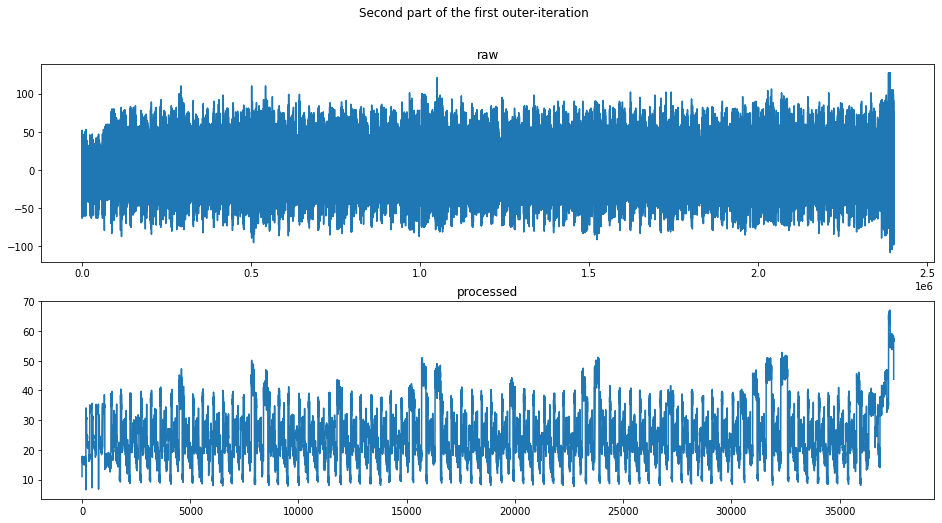

In [10]:
# loop_curve_2 will contain the second part of the outer-iteration
loop_curve_2 = curves[0][outer_iterations_bounds[0]+2400000:outer_iterations_bounds[0]+4800000]
proc_loop_curve_2 = simplify_pattern(loop_curve_2, decimation=64)

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].plot(loop_curve_2)
axes[0].set_title('raw')
axes[1].plot(proc_loop_curve_2)
axes[1].set_title('processed')
fig.suptitle("Second part of the first outer-iteration")
plt.show()

Number of detected peaks: 71


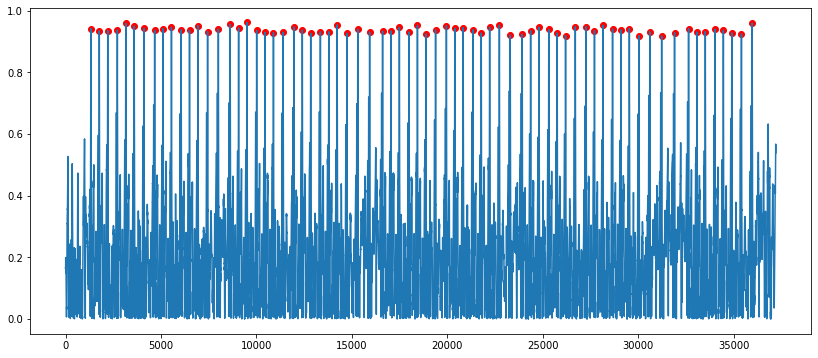

CPU times: user 3.41 s, sys: 91.8 ms, total: 3.5 s
Wall time: 3.33 s


In [11]:
%%time
pcc = pearson_xcorr(proc_loop_curve_2,proc_inner_pattern)

peaks = detect_peaks(np.abs(pcc), threshold=0.8, min_gap=100, keep='max')
print("Number of detected peaks: {}".format(len(peaks)))
plt.figure(figsize=(14,6))
plt.plot(np.abs(pcc))
plt.scatter(peaks,[abs(pcc[r]) for r in peaks],color='red')
plt.show()

We actually find $71$ occurrences what is a good point !
Let us now directly try on the entire outer-iteration to see if we obtain 142 peaks or more due to the remaining third part. We will also consider the 3 next outer-iterations (corresponding to non-zero syndrome).

In [12]:
%%time
for outer_idx in range(4):
    outer_iteration_curve = curves[0][outer_iterations_bounds[outer_idx]:outer_iterations_bounds[outer_idx+1]]
    proc_outer_iteration_curve = simplify_pattern(outer_iteration_curve, decimation=64)
    pcc = pearson_xcorr(proc_outer_iteration_curve,proc_inner_pattern)
    peaks = detect_peaks(np.abs(pcc), threshold=0.8, min_gap=100, keep='max')
    print("Number of peaks for outer-iteration number {}: {}".format(outer_idx,len(peaks)))

Number of peaks for outer-iteration number 0: 142
Number of peaks for outer-iteration number 1: 142
Number of peaks for outer-iteration number 2: 142
Number of peaks for outer-iteration number 3: 142
CPU times: user 45.9 s, sys: 1.66 s, total: 47.5 s
Wall time: 47.5 s


This works pretty well for the $4$ first outer-iterations. Let us now try on the remaining curves.

In [13]:
%%time
inner_decim  =  64
sos=butter(4, 0.01, output='sos')
inner_pattern = np.load(os.path.join(tmp_directory,'raw_inner_iteration_pattern_nonzero.npy'))
proc_inner_pattern = simplify_pattern(inner_pattern,decimation=inner_decim,sos=sos)

for curve_idx in range(1,20):
    outer_starts = outer_iterations_bounds_all[curve_idx]
    nb_peaks = []
    for outer_idx in range(4):
        outer_curve = curves[curve_idx][outer_iterations_bounds[outer_idx]:outer_iterations_bounds[outer_idx+1]]
        proc_outer_curve = simplify_pattern(outer_curve, decimation=inner_decim)
        inner_pcc = pearson_xcorr(proc_outer_curve,proc_inner_pattern)
        peaks = detect_peaks(np.abs(inner_pcc), threshold=0.8, min_gap=100, keep='max')
        nb_peaks.append(len(peaks))
    print("Number of peaks for curve number {}: {}".format(curve_idx,nb_peaks))

Number of peaks for curve number 1: [142, 142, 142, 142]
Number of peaks for curve number 2: [142, 142, 142, 142]
Number of peaks for curve number 3: [142, 142, 142, 142]
Number of peaks for curve number 4: [142, 142, 142, 142]
Number of peaks for curve number 5: [142, 142, 142, 142]
Number of peaks for curve number 6: [142, 142, 142, 142]
Number of peaks for curve number 7: [142, 142, 142, 142]
Number of peaks for curve number 8: [142, 142, 142, 142]
Number of peaks for curve number 9: [142, 142, 142, 142]
Number of peaks for curve number 10: [142, 142, 142, 142]
Number of peaks for curve number 11: [142, 142, 142, 142]
Number of peaks for curve number 12: [142, 142, 142, 142]
Number of peaks for curve number 13: [142, 142, 142, 142]
Number of peaks for curve number 14: [142, 142, 142, 142]
Number of peaks for curve number 15: [142, 142, 142, 142]
Number of peaks for curve number 16: [142, 142, 142, 142]
Number of peaks for curve number 17: [142, 142, 142, 142]
Number of peaks for cur

# Inner-Iterations when Syndrome is Zero

The outer-iterations corresponding to a null syndrome have a really different shape. We do not expect the selected patterns to also work on them.
Let us try anyway to see how far from a good result we are.

Number of peaks for outer-iteration number 4: 41


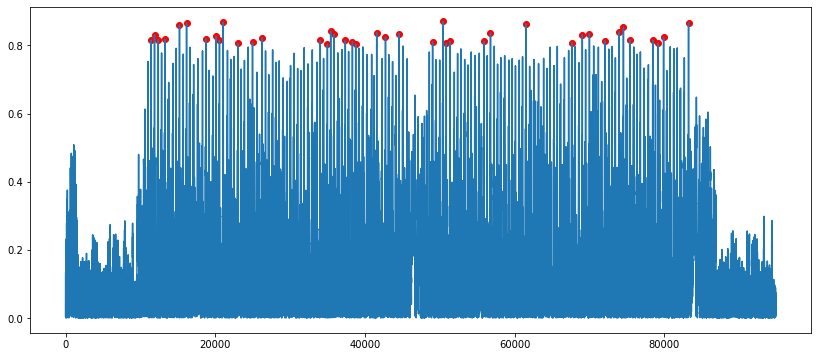

CPU times: user 13.5 s, sys: 292 ms, total: 13.8 s
Wall time: 13.6 s


In [14]:
%%time
outer_idx = 4
outer_curve = curves[0][outer_iterations_bounds[outer_idx]:outer_iterations_bounds[outer_idx+1]]
proc_outer_curve = simplify_pattern(outer_curve, decimation=64)
pcc = pearson_xcorr(proc_outer_curve,proc_inner_pattern)
peaks = detect_peaks(np.abs(pcc), threshold=0.8, min_gap=100, keep='max')
print("Number of peaks for outer-iteration number {}: {}".format(outer_idx,len(peaks)))

plt.figure(figsize=(14,6))
plt.plot(np.abs(pcc))
plt.scatter(peaks,[abs(pcc[r]) for r in peaks],color='red')
plt.show()

It seems that we indeed need some pattern adaptation for this particular case.
Let's find a pattern.

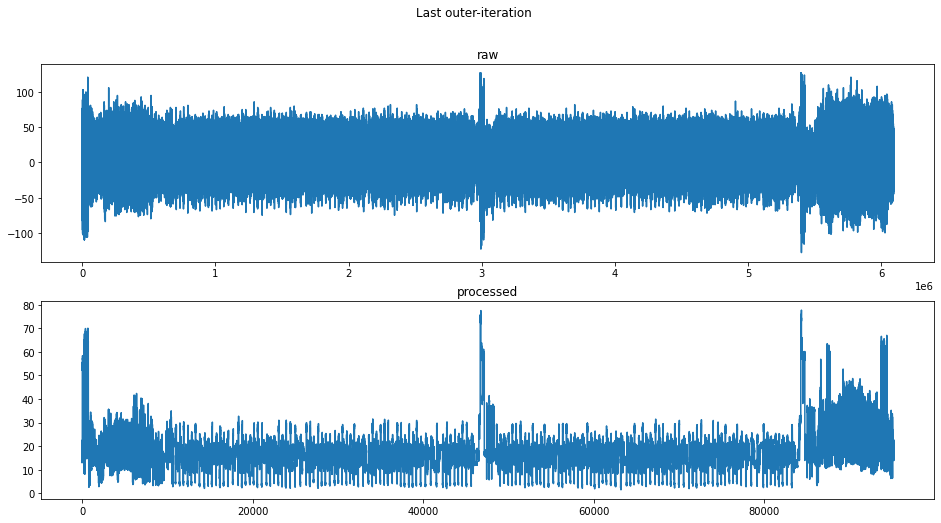

In [15]:
last_iteration_curve = curves[0][outer_iterations_bounds[-2]:outer_iterations_bounds[-1]]
proc_last_iteration_curve = simplify_pattern(last_iteration_curve, decimation=64)

fig, axes = plt.subplots(2,1,figsize=(16,8))
axes[0].plot(last_iteration_curve)
axes[0].set_title('raw')
axes[1].plot(proc_last_iteration_curve)
axes[1].set_title('processed')
fig.suptitle("Last outer-iteration")
plt.show()

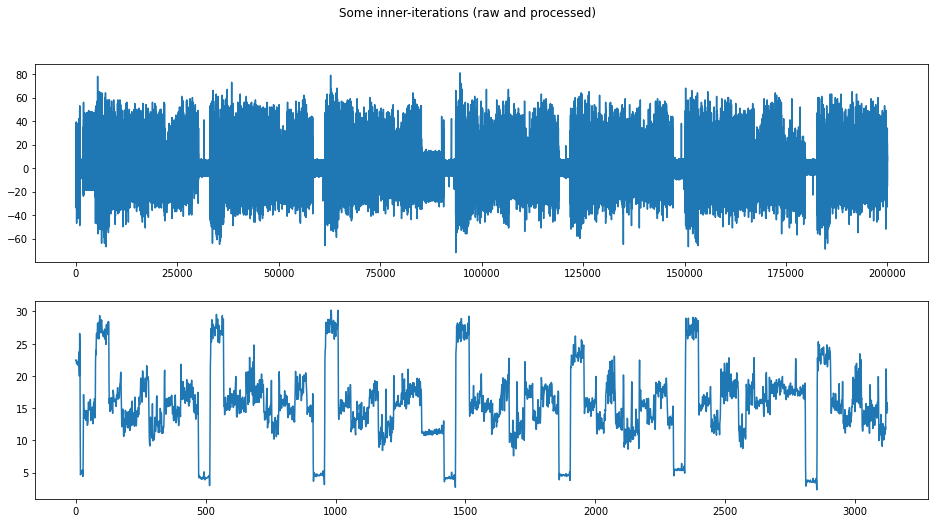

In [16]:
inner_patterns = curves[0][outer_iterations_bounds[-2]+700000:outer_iterations_bounds[-2]+900000]
proc_inner_patterns = simplify_pattern(inner_patterns, decimation=64)

fig, axes = plt.subplots(2,1,figsize=[16,8])
axes[0].plot(inner_patterns)
axes[1].plot(proc_inner_patterns)
fig.suptitle("Some inner-iterations (raw and processed)")
plt.show()

Again we see that the end of each iteration varies a bit. We will thus concentrate on the first part of the iteration to select our pattern. More precisely, there is a first huge rising which seems very characteristic except for the first pattern. Let us see if it is indeed the case.

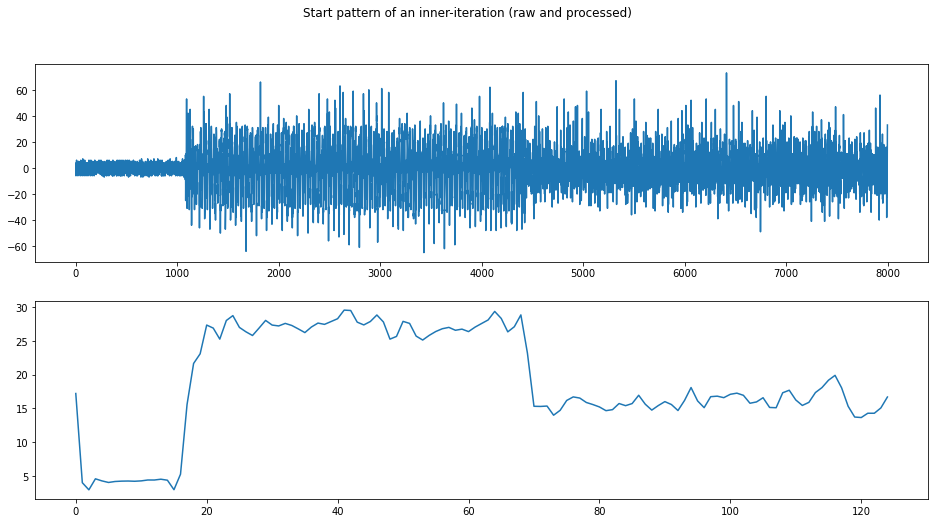

In [17]:
inner_pattern = curves[0][outer_iterations_bounds[-2]+732000:outer_iterations_bounds[-2]+740000]

proc_inner_pattern = simplify_pattern(inner_pattern, decimation=64)

fig, axes = plt.subplots(2,1,figsize=[16,8])
axes[0].plot(inner_pattern)
axes[1].plot(proc_inner_pattern)
fig.suptitle("Start pattern of an inner-iteration (raw and processed)")
plt.show()
np.save(os.path.join(tmp_directory,'raw_inner_iteration_pattern_zero.npy'),inner_pattern)

Number of peaks for outer-iteration number 4: 140


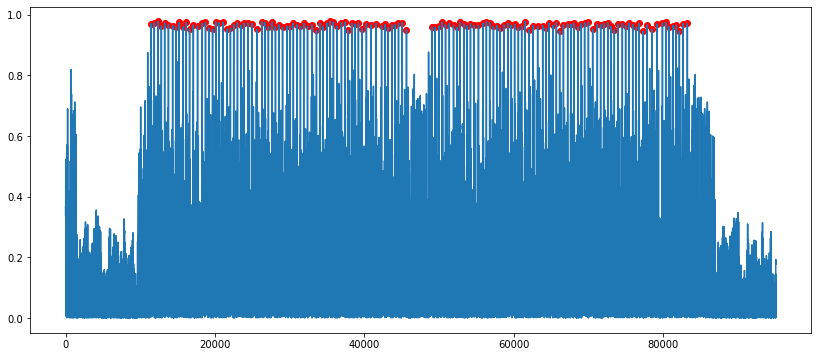

Number of peaks for outer-iteration number 5: 140


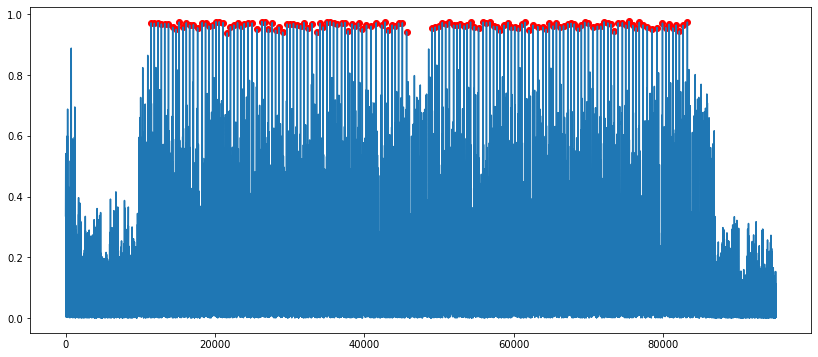

Number of peaks for outer-iteration number 6: 140


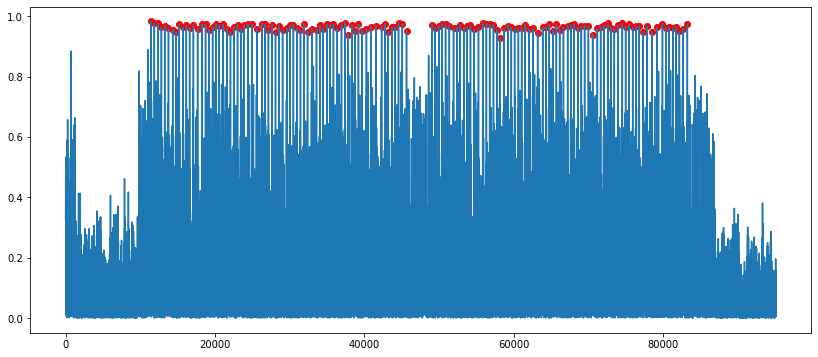

CPU times: user 34.5 s, sys: 1.06 s, total: 35.6 s
Wall time: 35.1 s


In [18]:
%%time
for outer_idx in [4,5,6]:
    outer_curve = curves[0][outer_iterations_bounds[outer_idx]:outer_iterations_bounds[outer_idx+1]]
    proc_outer_curve = simplify_pattern(outer_curve, decimation=64)
    pcc = pearson_xcorr(proc_outer_curve,proc_inner_pattern)
    peaks = detect_peaks(np.abs(pcc), threshold=0.91, min_gap=100, keep='max')
    print("Number of peaks for outer-iteration number {}: {}".format(outer_idx,len(peaks)))

    plt.figure(figsize=(14,6))
    plt.plot(np.abs(pcc))
    plt.scatter(peaks,[abs(pcc[r]) for r in peaks],color='red')
    plt.show()

It seems that indeed all peaks but the first are correctly detected.
Let us take a look at the intervals between peaks.

Minimum interval: 438


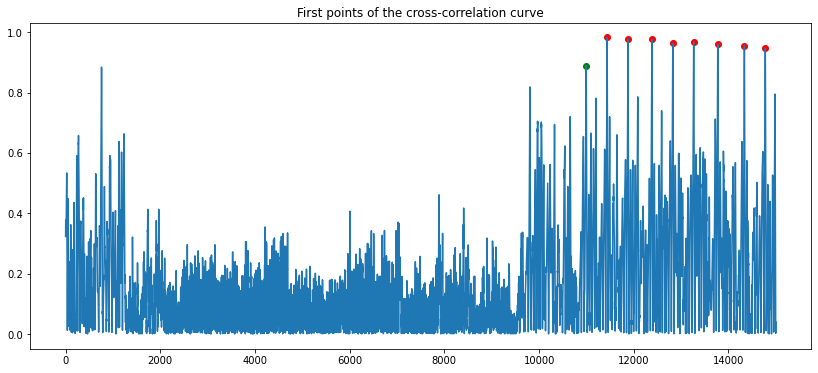

Interval between actual first peak and first (detected) peak: 441


In [19]:
print("Minimum interval:",np.min(np.array(peaks[1:])-np.array(peaks[:-1])))

plt.figure(figsize=(14,6))
plt.plot(np.abs(pcc[:15000]))
plt.scatter(peaks[:8],[abs(pcc[r]) for r in peaks[:8]],color='red')
first_peak = 10996
plt.scatter([first_peak],[abs(pcc[first_peak])],color='green')
plt.title("First points of the cross-correlation curve")
plt.show()

print("Interval between actual first peak and first (detected) peak:",peaks[0]-first_peak)

So we see that the first peak distance to the first detected peak is close to the minimum interval between other peaks and that its correlation is high enough to be detected. We can thus make some dedicated rule to detect it.

In [20]:
def detect_first_peak(pcc,peaks,wrange=20):
    peaks_np = np.array(peaks)
    min_interval = np.min(peaks_np[1:] - peaks_np[:-1])
    window = np.abs(pcc)[peaks[0]-min_interval-wrange:peaks[0]-min_interval+wrange]
    first_peak = peaks[0]-min_interval-wrange+np.argmax(window)
    return first_peak
new_peak = detect_first_peak(pcc,peaks)
assert new_peak == first_peak

Now that we have this routine let us test it on all the 20 curves.

In [21]:
%%time
inner_decim  =  64
sos=butter(4, 0.01, output='sos')
for curve_idx in range(20):
    outer_starts = outer_iterations_bounds_all[curve_idx]
    nb_peaks = []
    for outer_idx in [4,5,6]:
        outer_curve = curves[curve_idx][outer_starts[outer_idx]:outer_starts[outer_idx+1]]
        proc_outer_curve = simplify_pattern(outer_curve, decimation=inner_decim)
        pcc_inner = pearson_xcorr(proc_outer_curve,proc_inner_pattern)
        peaks = detect_peaks(np.abs(pcc_inner), threshold=0.91, min_gap=100, keep='max')
        if len(peaks) == 140:
            new_peak1 = detect_first_peak(pcc_inner,peaks[:70])
            new_peak2 = detect_first_peak(pcc_inner,peaks[70:])
            peaks += [new_peak1 , new_peak2]
        nb_peaks.append(len(peaks))
    print("Number of peaks for curve number {}: {}".format(curve_idx,nb_peaks))

Number of peaks for curve number 0: [142, 142, 142]
Number of peaks for curve number 1: [142, 142, 142]
Number of peaks for curve number 2: [142, 142, 142]
Number of peaks for curve number 3: [142, 142, 142]
Number of peaks for curve number 4: [142, 142, 142]
Number of peaks for curve number 5: [142, 142, 142]
Number of peaks for curve number 6: [142, 142, 142]
Number of peaks for curve number 7: [142, 142, 142]
Number of peaks for curve number 8: [142, 142, 142]
Number of peaks for curve number 9: [142, 142, 142]
Number of peaks for curve number 10: [142, 142, 142]
Number of peaks for curve number 11: [142, 142, 142]
Number of peaks for curve number 12: [142, 142, 142]
Number of peaks for curve number 13: [142, 142, 142]
Number of peaks for curve number 14: [142, 142, 142]
Number of peaks for curve number 15: [142, 142, 142]
Number of peaks for curve number 16: [142, 142, 142]
Number of peaks for curve number 17: [142, 142, 142]
Number of peaks for curve number 18: [142, 142, 142]
Num

## Refining Iteration split

If we take a closer look at correlation peaks, we see that each one is composed of more than a single sample.
Also, correlation are very close and the decimation rate is quite high so with high probability, the inner-iterations obtained are not perfectly synchronized. This can be verified by plotting some of them. Let us split the last outer-iteration of the first curve into inner-iteration patterns.

First, we compute the pattern starting points.

In [22]:
%%time
inner_decim  =  64
outer_idx = 6
sos=butter(4, 0.01, output='sos')
outer_starts = outer_iterations_bounds_all[0]
outer_curve = curves[curve_idx][outer_starts[outer_idx]:outer_starts[outer_idx+1]]
proc_outer_curve = simplify_pattern(outer_curve, decimation=inner_decim)
pcc_inner = pearson_xcorr(proc_outer_curve,proc_inner_pattern)
peaks = detect_peaks(np.abs(pcc_inner), threshold=0.9, min_gap=100, keep='max')
if len(peaks) == 140:
    new_peak1 = detect_first_peak(pcc_inner,peaks[:70])
    new_peak2 = detect_first_peak(pcc_inner,peaks[70:])

CPU times: user 11.7 s, sys: 896 ms, total: 12.6 s
Wall time: 12.5 s


Now we can estimate the minimum size of an inner-iteration pattern and split the curve into 142 inner-iterations.

In [23]:
all_peaks = peaks + [new_peak1, new_peak2]
all_peaks.sort()
inner_starts = inner_decim * np.array( all_peaks ) 
pattern_length = np.min(inner_starts[1:]-inner_starts[:-1])
inner_iterations = [ outer_curve[start:start+pattern_length] for start in inner_starts ]
inner_iterations = np.array(inner_iterations,dtype=float)

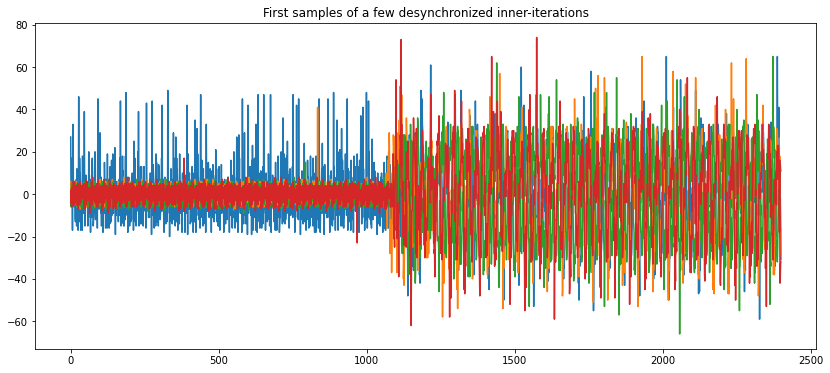

In [24]:
start, end = 0, 2400
plt.figure(figsize=(14,6))
for i in range(4):
    plt.plot(range(start,end),inner_iterations[i][start:end])
plt.title('First samples of a few desynchronized inner-iterations')
plt.show()

We see that the patterns we are interested in starts after point 1100, let us zoom a bit.

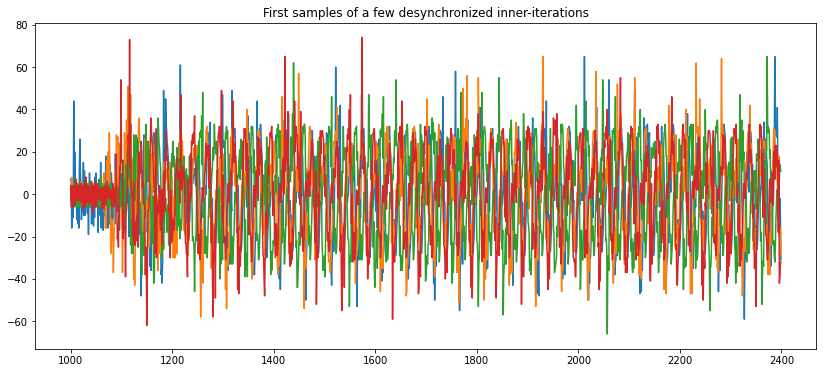

In [25]:
start, end = 1000, 2400
plt.figure(figsize=(14,6))
for i in range(4):
    plt.plot(range(start,end),inner_iterations[i][start:end])
plt.title('First samples of a few desynchronized inner-iterations')
plt.show()

We see a desynchronization that can also be observed when plotting the average of all inner-iteration curves wich hsa a too low amplitude and no clear pattern inside.

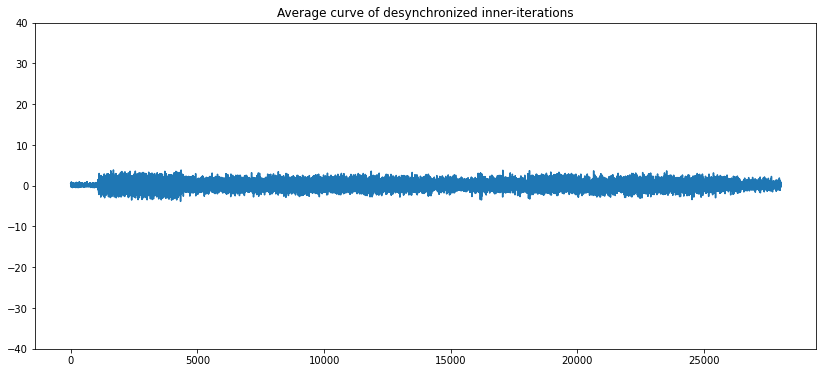

In [26]:
plt.figure(figsize=(14,6))
plt.ylim(-40,40)
plt.plot(np.mean(inner_iterations,0))
plt.title('Average curve of desynchronized inner-iterations')
plt.show()

Let us now try to resynchronize this.
For this, we will use the first peak with high amplitude.
Notice that we do not consider the first inner-iteration now since the beggining of the corresponding pattern is a bit specific.

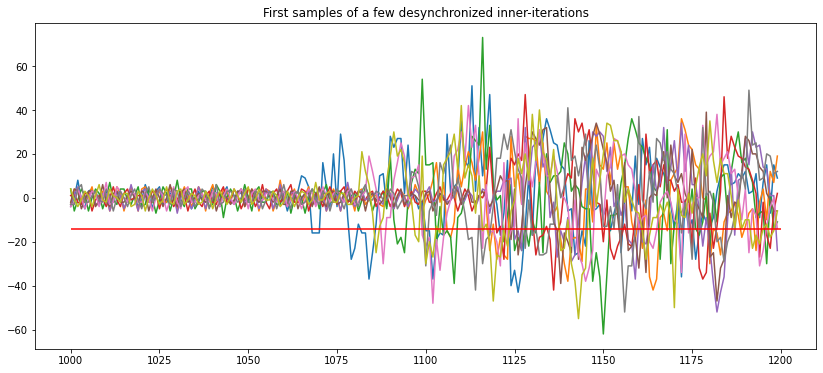

In [27]:
start, end = 1000, 1200
plt.figure(figsize=(14,6))
for i in range(1,10):
    plt.plot(range(start,end),inner_iterations[i][start:end])
plt.hlines([-14],xmin=start,xmax=end,color='red')
plt.title('First samples of a few desynchronized inner-iterations')
plt.show()

We see that a line at $y=-14$ seems to be perfect for detecting the first peak.
Let us try this. Namely, we now consider a pattern as starting 5 samples before this first peak and have a length of $\texttt{pattern_length}-1200$.

Concerning the first inner-iterations of each two parts of the outer-iteration let us take a look.

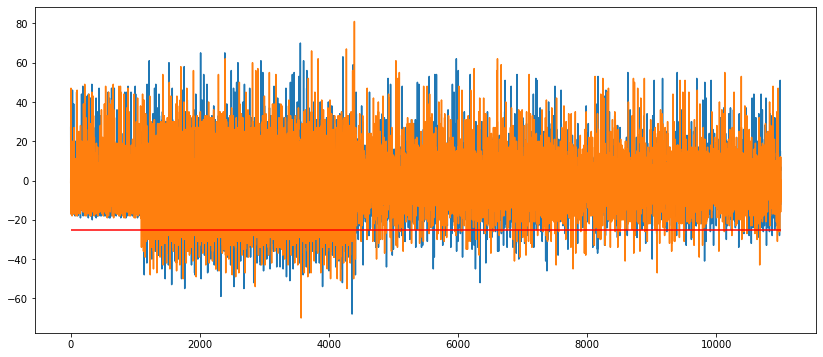

In [28]:
plt.figure(figsize=(14,6))
plt.plot(inner_iterations[0][:11000])
plt.plot(inner_iterations[71][:11000])
plt.hlines([-25],xmin=0,xmax=11000,color='red')
plt.show()

Here, due to some noise, the threshold should be adapted to $-25$.

In [28]:
sync_inner_iterations = []
for i in range(len(inner_iterations)):
    start = 1000
    threshold = -14
    if i in [0,71]:
        threshold = -25
    start += np.where(inner_iterations[i][start:start+1000]<threshold)[0][0] - 5
    sync_inner_iterations.append(inner_iterations[i][start:start+pattern_length-1200])

sync_inner_iterations = np.array(sync_inner_iterations,dtype=float)

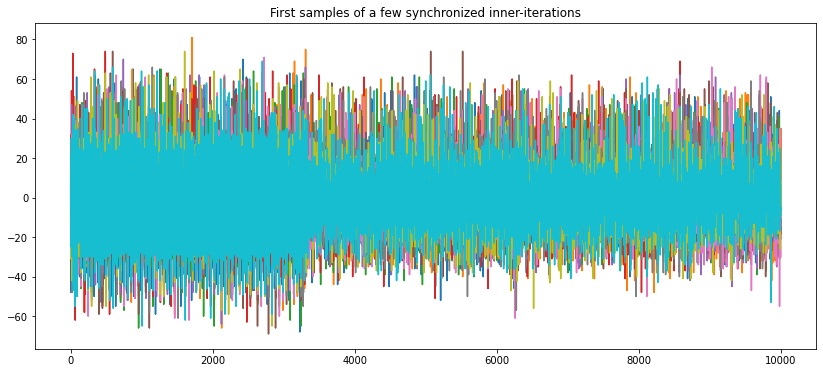

In [30]:
start, end = 0, 10000
plt.figure(figsize=(14,6))
for i in range(10):
    plt.plot(range(start,end),sync_inner_iterations[i][start:end])
plt.title('First samples of a few synchronized inner-iterations')
plt.show()

Let us now see the impact on the average curve.

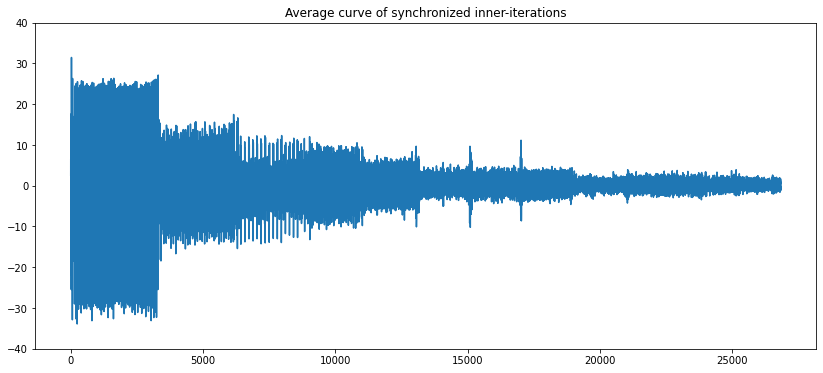

In [31]:
plt.figure(figsize=(14,6))
plt.ylim(-40,40)
plt.plot(np.mean(sync_inner_iterations,0))
plt.title('Average curve of synchronized inner-iterations')
plt.show()

It is way nicer that before. We are now ready to take a look at clustering to extract information on the positions of ones in the parity-check matrix !